# Loan Default Prediction - Part 11 - Feature Discretization with Gradient Boosted Decision Trees

This is an exploratory project for me to apply what I have learned in the Data Science and Machine Learning courses that I took this year. The data is from a Kaggle competition [Loan Default Prediction](https://www.kaggle.com/c/loan-default-prediction). 

This is Part 11 of the project: Feature Discretization with Gradient Boosted Decision Trees.

In this part, I will perform a similar feature discretization to the one in Part 8, but instead of using decision paths from Random Forests, I will be using leaf nodes of Gradient Boosted Decision Trees.

I will first load the data and train the best model from the previous part.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import time
import project_utils as utils
import project_xgb_utils as xgb_utils

In [2]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = utils.load_csv('train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

# Load the data into the XGBoost data structure
import xgboost as xgb
d_all = xgb.DMatrix(X.values, y.values)
d_train = xgb.DMatrix(X_train.values, y_train.values)
d_valid = xgb.DMatrix(X_valid.values, y_valid.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1789)
memory usage: 1.4 GB


In [3]:
# Define parameters

param = {'eta': 0.5, 
         'objective': 'binary:logistic', 
         'eval_metric': 'auc', 
         'max_depth': 6, 
         'min_child_weight': 4, 
         'gamma': 0, 
         'subsample': 1, 
         'colsample_bytree': 1, 
         'lambda': 1, 
         'alpha': 0}
num_boost_round = 10     # Same as the number of trees in Part 08

Time elapsed (Training): 8.8572 s
Accuracy Score (Training): 0.907450
ROCAUC Score (Training): 0.789463
PRAUC Score (Training): 0.219629
Accuracy Score (Validation): 0.912064
ROCAUC Score (Validation): 0.701739
PRAUC Score (Validation): 0.090471
Time elapsed (Evaluation): 0.5498 s


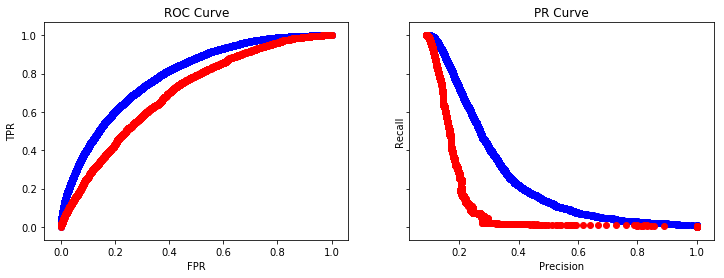

In [4]:
# Train the model

bst, fit_time = xgb_utils.train_model(param, d_train, num_boost_round)
acc_score, rocauc_score, prauc_score, eval_time = xgb_utils.evaluate(bst, d_train, y_train, d_valid, y_valid)

## Extracting Leaf Node Predictions as Features

Let's see what the leaf node predictions look like.

In [5]:
y_predicted = bst.predict(d_all, pred_leaf=True)
y_predicted.shape
y_predicted

array([[ 60,  86,  65, ...,  61,  73,  65],
       [ 91,  66, 101, ...,  61,  80,  65],
       [ 53,  74,  72, ...,  61,  74,  66],
       ...,
       [ 77,  61,  61, ...,  49,  66,  63],
       [ 79,  67, 107, ...,  61,  89,  65],
       [ 77,  71,  91, ...,  58,  66,  63]])

The shape is [n_samples, n_trees]. Each leaf is represented by an integer. Therefore, I will perform one-hot encoding to make them usable features.

In [6]:
col_names = []
for c in range(10):
    col_names.append('leaf_tree_{}'.format(c))

df_discretized = pd.DataFrame(data=y_predicted, columns=col_names)

cols = []
for c in df_discretized.columns:
    cols.append([c])

In [7]:
# Replace categorical features with one-hot encoding
from sklearn_pandas import gen_features
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder

feature_def = gen_features(
    columns=cols,
    classes=[OneHotEncoder] 
)

mapper = DataFrameMapper(feature_def, default=None, input_df=True, df_out=True)
df_discretized = mapper.fit_transform(df_discretized)
df_discretized.info()
print(df_discretized.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 504 entries, leaf_tree_0_0 to leaf_tree_9_40
dtypes: float64(504)
memory usage: 405.6 MB
       leaf_tree_0_0  leaf_tree_0_1  leaf_tree_0_2  leaf_tree_0_3  \
count  105471.000000  105471.000000  105471.000000  105471.000000   
mean        0.000284       0.000190       0.070692       0.000171   
std         0.016863       0.013769       0.256312       0.013063   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       leaf_tree_0_4  leaf_tree_0_5  leaf_tree_0_6  leaf_tree_0_7  \
count  105471.000000  105471.000000  105471.000000  105471.000000   
mean        0.000341       0.000237       0.000199       0.03011

## Using the Decision Path Features in Logistic Regression

I will use these new features to train a Logistic Regression model. First, I will train the reference model.

Time elapsed (Training): 45.8064 s
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906312
ROCAUC Score (Training): 0.736909
PRAUC Score (Training): 0.120929
Accuracy (Validation): 0.911780
ROCAUC Score (Validation): 0.712660
PRAUC Score (Validation): 0.091904
Time elapsed (Evaluation): 0.9427 s


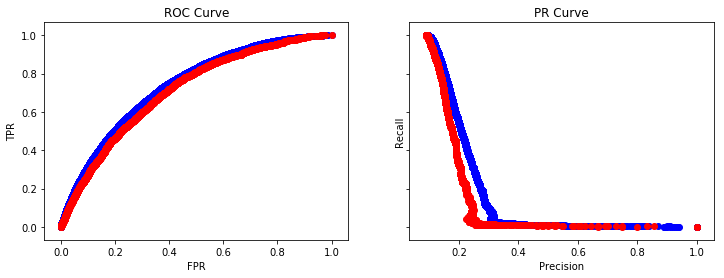

In [8]:
# Reference model trained with original normalized features, no class weights (Best result obtained in Part 03)

from sklearn import linear_model
clf = linear_model.LogisticRegression(C=0.01)
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

In [9]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}

Time elapsed (Training): 192.6845 s
LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.651453
ROCAUC Score (Training): 0.744557
PRAUC Score (Training): 0.118671
Accuracy (Validation): 0.641242
ROCAUC Score (Validation): 0.712974
PRAUC Score (Validation): 0.093177
Time elapsed (Evaluation): 0.8917 s


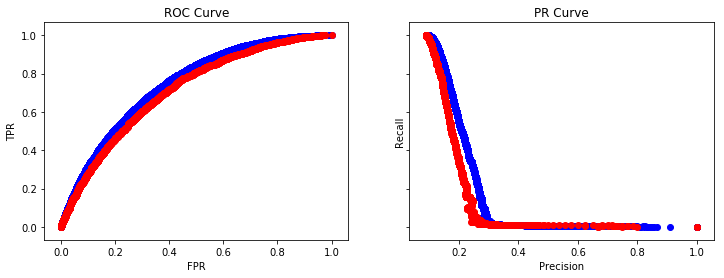

In [10]:
# Reference model trained with original normalized features, with class weights

from sklearn import linear_model
clf = linear_model.LogisticRegression(class_weight=class_weight, C=0.01)
fit_time = utils.train_model(clf, X_train, y_train)
acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)

Now, I will try using the discretized features only to train logistic regression models with different regularizations.

In [11]:
# Change X to discretized features

X = df_discretized # Features
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

In [12]:
# Define a set of Cs to try

Cs = [1e-1, 5e-2, 2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 5e-4, 2e-4, 1e-4]

----- C = 0.100000 -----
Time elapsed (Training): 0.4848 s
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.907841
ROCAUC Score (Training): 0.797237
PRAUC Score (Training): 0.226176
Accuracy (Validation): 0.910974
ROCAUC Score (Validation): 0.695559
PRAUC Score (Validation): 0.084506
Time elapsed (Evaluation): 0.4968 s


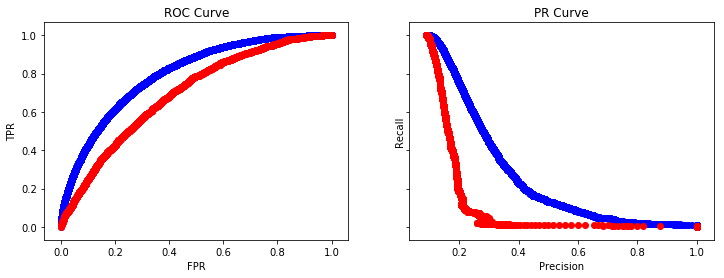

----- C = 0.050000 -----
Time elapsed (Training): 0.5068 s
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.907142
ROCAUC Score (Training): 0.791291
PRAUC Score (Training): 0.208768
Accuracy (Validation): 0.911496
ROCAUC Score (Validation): 0.698180
PRAUC Score (Validation): 0.085805
Time elapsed (Evaluation): 0.4609 s


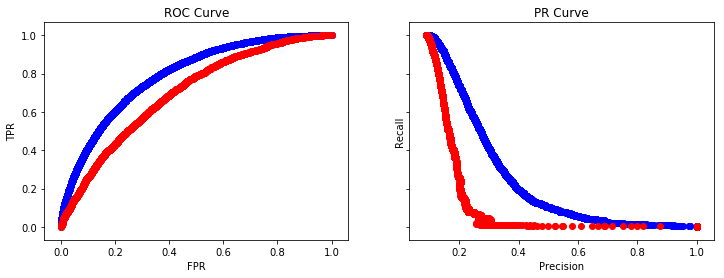

----- C = 0.020000 -----
Time elapsed (Training): 0.3889 s
LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906371
ROCAUC Score (Training): 0.780220
PRAUC Score (Training): 0.180031
Accuracy (Validation): 0.912017
ROCAUC Score (Validation): 0.700490
PRAUC Score (Validation): 0.085550
Time elapsed (Evaluation): 0.5108 s


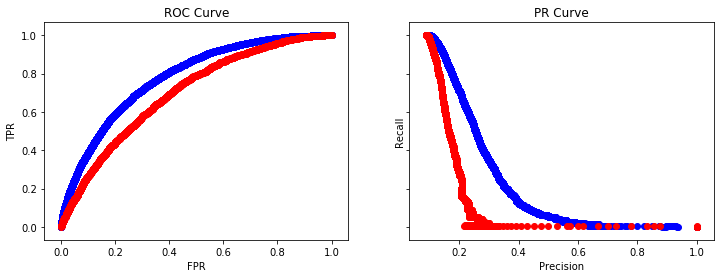

----- C = 0.010000 -----
Time elapsed (Training): 0.3389 s
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906134
ROCAUC Score (Training): 0.770454
PRAUC Score (Training): 0.159063
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.701003
PRAUC Score (Validation): 0.083293
Time elapsed (Evaluation): 0.4928 s


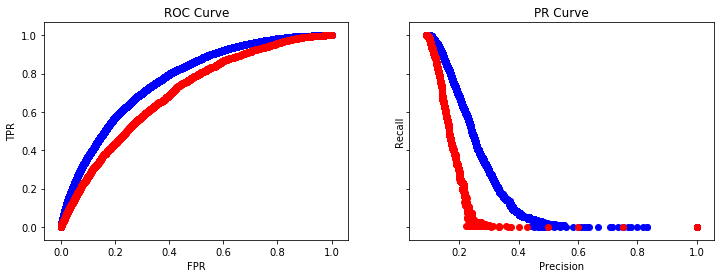

----- C = 0.005000 -----
Time elapsed (Training): 0.3289 s
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.760225
PRAUC Score (Training): 0.142743
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.700209
PRAUC Score (Validation): 0.082157
Time elapsed (Evaluation): 0.5118 s


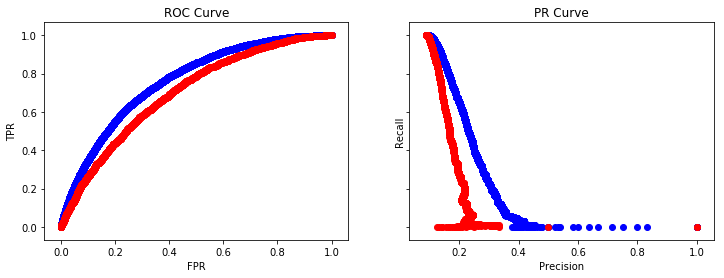

----- C = 0.002000 -----
Time elapsed (Training): 0.2719 s
LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.745853
PRAUC Score (Training): 0.127163
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.695926
PRAUC Score (Validation): 0.083379
Time elapsed (Evaluation): 0.4998 s


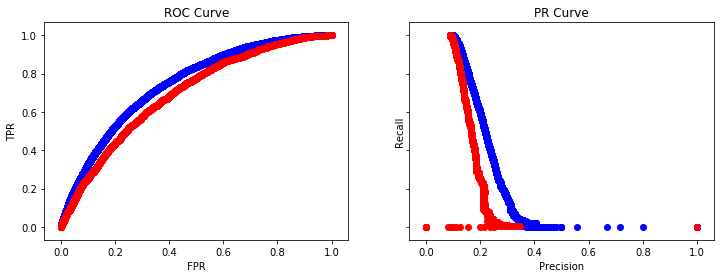

----- C = 0.001000 -----
Time elapsed (Training): 0.2829 s
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.733123
PRAUC Score (Training): 0.117369
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.688428
PRAUC Score (Validation): 0.120437
Time elapsed (Evaluation): 0.4908 s


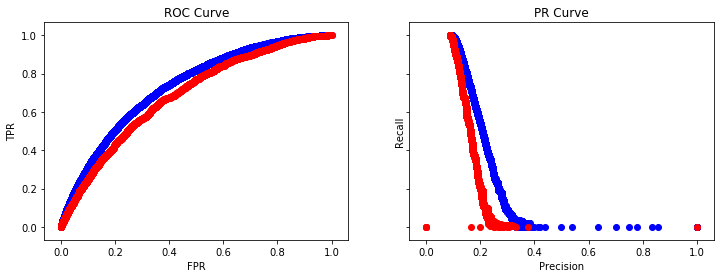

----- C = 0.000500 -----
Time elapsed (Training): 0.2239 s
LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.716021
PRAUC Score (Training): 0.105324
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.674740
PRAUC Score (Validation): 0.113953
Time elapsed (Evaluation): 0.5088 s


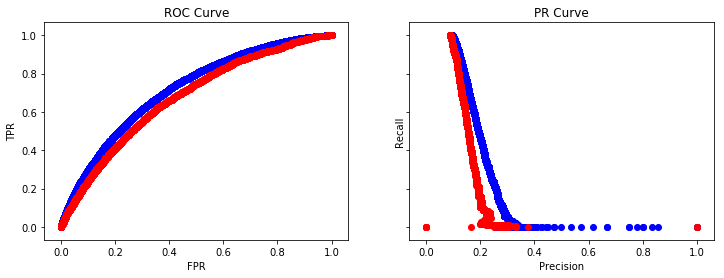

----- C = 0.000200 -----
Time elapsed (Training): 0.2179 s
LogisticRegression(C=0.0002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.676981
PRAUC Score (Training): 0.075160
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.639314
PRAUC Score (Validation): 0.063349
Time elapsed (Evaluation): 0.5188 s


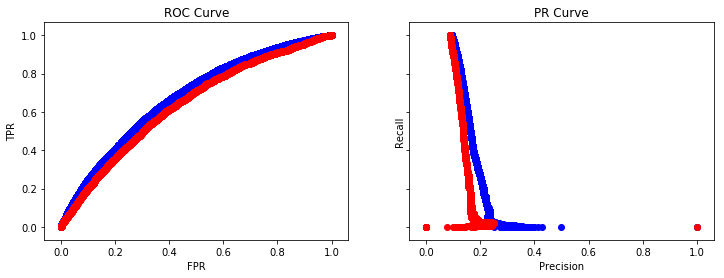

----- C = 0.000100 -----
Time elapsed (Training): 0.2429 s
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.631333
PRAUC Score (Training): 0.045223
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.597573
PRAUC Score (Validation): 0.072421
Time elapsed (Evaluation): 0.5468 s


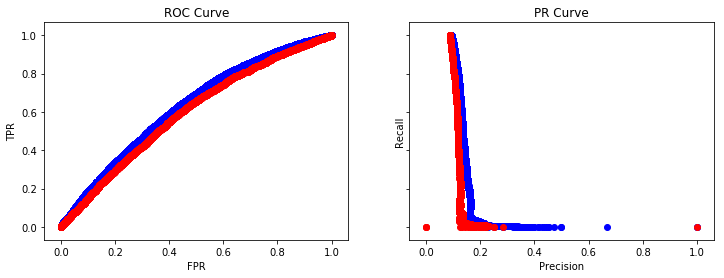

In [13]:
# Train the models with discretized features only

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

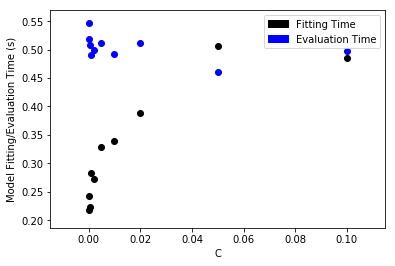

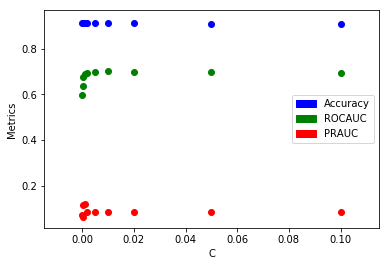

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.910974  0.695559  0.084506    0.484848     0.496839
1  0.0500    0.911496  0.698180  0.085805    0.506840     0.460851
2  0.0200    0.912017  0.700490  0.085550    0.388872     0.510834
3  0.0100    0.911970  0.701003  0.083293    0.338894     0.492841
4  0.0050    0.911827  0.700209  0.082157    0.328893     0.511834
5  0.0020    0.911827  0.695926  0.083379    0.271925     0.499837
6  0.0010    0.911827  0.688428  0.120437    0.282909     0.490841
7  0.0005    0.911827  0.674740  0.113953    0.223927     0.508835
8  0.0002    0.911827  0.639314  0.063349    0.217927     0.518832
9  0.0001    0.911827  0.597573  0.072421    0.242919     0.546827


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.911742   0.679142   0.087485    0.328796     0.503837
std     0.032431    0.000302   0.

In [14]:
utils.plot_metrics (Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

The resulting ROCAUC is 0.701, which is exactly the same as the ROCAUC I obtained from the XGBoost model. It means the XGBoost decisions are incorporated into these features and passed to logistic regression. Next, I will add the class weights.

----- C = 0.100000 -----
Time elapsed (Training): 0.9057 s
LogisticRegression(C=0.1, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.684377
ROCAUC Score (Training): 0.803622
PRAUC Score (Training): 0.234350
Accuracy (Validation): 0.656696
ROCAUC Score (Validation): 0.689250
PRAUC Score (Validation): 0.078526
Time elapsed (Evaluation): 0.5178 s


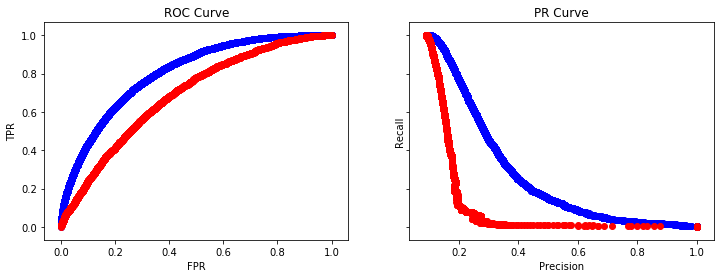

----- C = 0.050000 -----
Time elapsed (Training): 0.8647 s
LogisticRegression(C=0.05, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.681817
ROCAUC Score (Training): 0.801572
PRAUC Score (Training): 0.226879
Accuracy (Validation): 0.654752
ROCAUC Score (Validation): 0.692069
PRAUC Score (Validation): 0.080502
Time elapsed (Evaluation): 0.5128 s


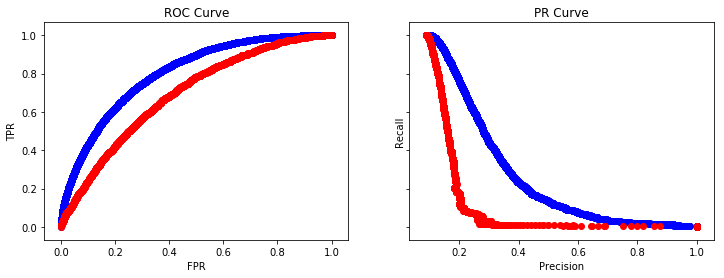

----- C = 0.020000 -----
Time elapsed (Training): 0.6068 s
LogisticRegression(C=0.02, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.675785
ROCAUC Score (Training): 0.796246
PRAUC Score (Training): 0.209181
Accuracy (Validation): 0.650676
ROCAUC Score (Validation): 0.695977
PRAUC Score (Validation): 0.082528
Time elapsed (Evaluation): 0.4898 s


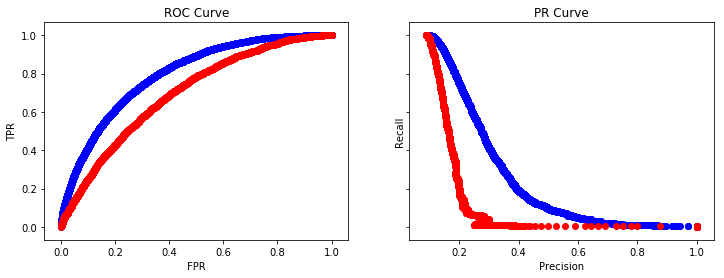

----- C = 0.010000 -----
Time elapsed (Training): 0.5568 s
LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.670274
ROCAUC Score (Training): 0.789639
PRAUC Score (Training): 0.190344
Accuracy (Validation): 0.646551
ROCAUC Score (Validation): 0.698564
PRAUC Score (Validation): 0.083417
Time elapsed (Evaluation): 0.5388 s


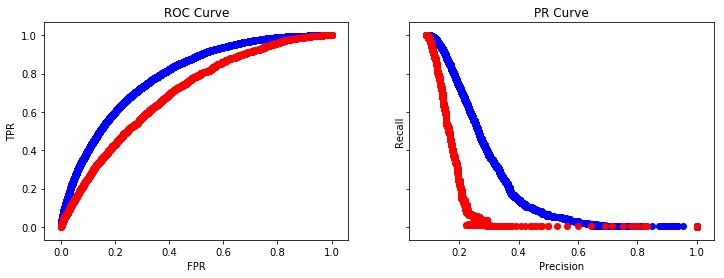

----- C = 0.005000 -----
Time elapsed (Training): 0.4569 s
LogisticRegression(C=0.005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.663684
ROCAUC Score (Training): 0.780892
PRAUC Score (Training): 0.169469
Accuracy (Validation): 0.642617
ROCAUC Score (Validation): 0.700385
PRAUC Score (Validation): 0.082236
Time elapsed (Evaluation): 0.4938 s


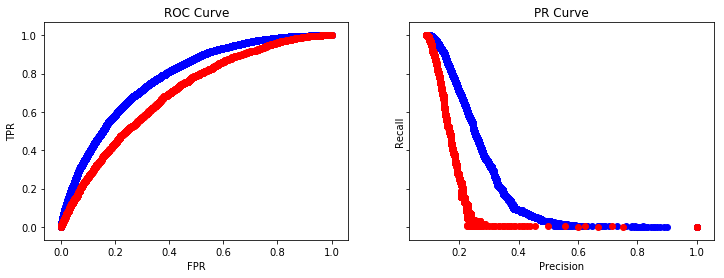

----- C = 0.002000 -----
Time elapsed (Training): 0.4139 s
LogisticRegression(C=0.002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.654060
ROCAUC Score (Training): 0.767305
PRAUC Score (Training): 0.144699
Accuracy (Validation): 0.638113
ROCAUC Score (Validation): 0.701361
PRAUC Score (Validation): 0.079861
Time elapsed (Evaluation): 0.5578 s


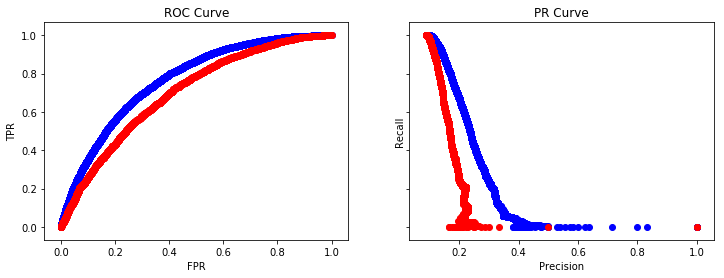

----- C = 0.001000 -----
Time elapsed (Training): 0.2919 s
LogisticRegression(C=0.001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.647803
ROCAUC Score (Training): 0.756554
PRAUC Score (Training): 0.130725
Accuracy (Validation): 0.636217
ROCAUC Score (Validation): 0.700934
PRAUC Score (Validation): 0.082857
Time elapsed (Evaluation): 0.5368 s


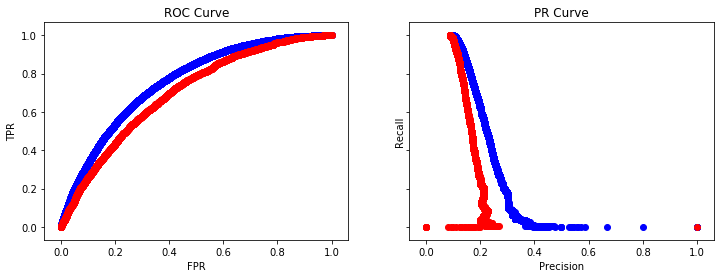

----- C = 0.000500 -----
Time elapsed (Training): 0.2799 s
LogisticRegression(C=0.0005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.641758
ROCAUC Score (Training): 0.746112
PRAUC Score (Training): 0.119501
Accuracy (Validation): 0.633088
ROCAUC Score (Validation): 0.699541
PRAUC Score (Validation): 0.125281
Time elapsed (Evaluation): 0.5198 s


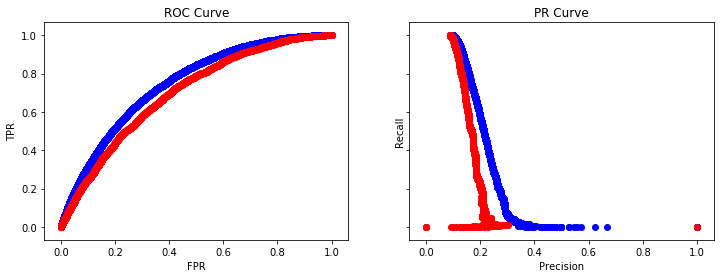

----- C = 0.000200 -----
Time elapsed (Training): 0.2459 s
LogisticRegression(C=0.0002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.632478
ROCAUC Score (Training): 0.733771
PRAUC Score (Training): 0.108159
Accuracy (Validation): 0.628206
ROCAUC Score (Validation): 0.696455
PRAUC Score (Validation): 0.127972
Time elapsed (Evaluation): 0.4748 s


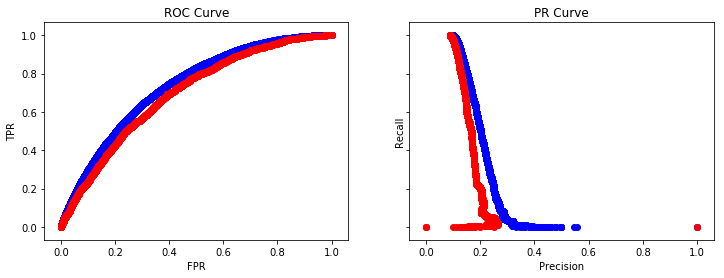

----- C = 0.000100 -----
Time elapsed (Training): 0.2089 s
LogisticRegression(C=0.0001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.622843
ROCAUC Score (Training): 0.726223
PRAUC Score (Training): 0.102293
Accuracy (Validation): 0.619863
ROCAUC Score (Validation): 0.693705
PRAUC Score (Validation): 0.123156
Time elapsed (Evaluation): 0.5158 s


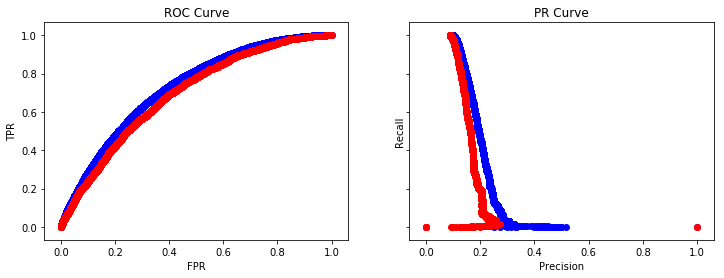

In [15]:
# Train the models with discretized features only

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(class_weight=class_weight, C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

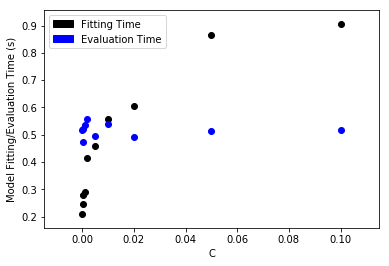

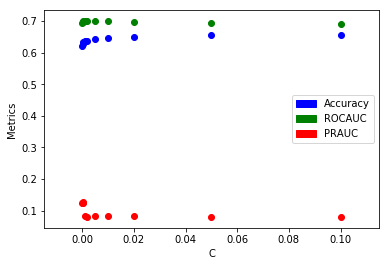

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.656696  0.689250  0.078526    0.905709     0.517832
1  0.0500    0.654752  0.692069  0.080502    0.864721     0.512834
2  0.0200    0.650676  0.695977  0.082528    0.606801     0.489844
3  0.0100    0.646551  0.698564  0.083417    0.556823     0.538826
4  0.0050    0.642617  0.700385  0.082236    0.456853     0.493841
5  0.0020    0.638113  0.701361  0.079861    0.413887     0.557819
6  0.0010    0.636217  0.700934  0.082857    0.291907     0.536827
7  0.0005    0.633088  0.699541  0.125281    0.279926     0.519830
8  0.0002    0.628206  0.696455  0.127972    0.245918     0.474847
9  0.0001    0.619863  0.693705  0.123156    0.208932     0.515835


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.640678   0.696824   0.094634    0.483148     0.515833
std     0.032431    0.011859   0.

In [16]:
utils.plot_metrics (Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

Similar to before, adding class weights did not help much with ROCAUC and PRAUC, but made the accuracy drop.

Finally, I will combine the original processed features with the discretized features to train models.

In [17]:
df_combined = pd.concat([X, df_discretized], axis=1)
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

----- C = 0.100000 -----
Time elapsed (Training): 0.6648 s
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.907841
ROCAUC Score (Training): 0.797237
PRAUC Score (Training): 0.226176
Accuracy (Validation): 0.910974
ROCAUC Score (Validation): 0.695559
PRAUC Score (Validation): 0.084506
Time elapsed (Evaluation): 0.4928 s


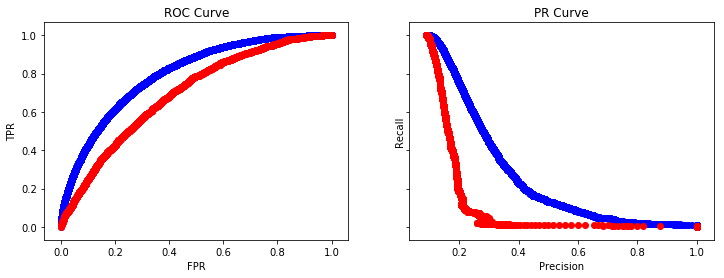

----- C = 0.050000 -----
Time elapsed (Training): 0.5758 s
LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.907142
ROCAUC Score (Training): 0.791291
PRAUC Score (Training): 0.208768
Accuracy (Validation): 0.911496
ROCAUC Score (Validation): 0.698180
PRAUC Score (Validation): 0.085805
Time elapsed (Evaluation): 0.4868 s


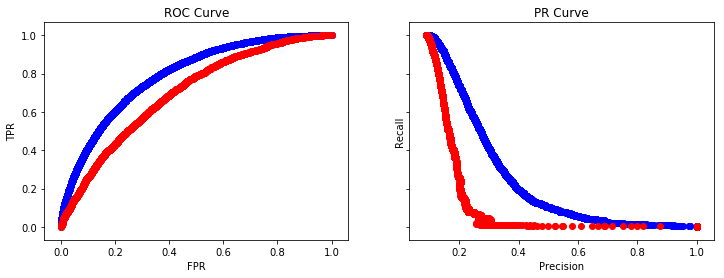

----- C = 0.020000 -----
Time elapsed (Training): 0.3719 s
LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906371
ROCAUC Score (Training): 0.780220
PRAUC Score (Training): 0.180031
Accuracy (Validation): 0.912017
ROCAUC Score (Validation): 0.700490
PRAUC Score (Validation): 0.085550
Time elapsed (Evaluation): 0.4908 s


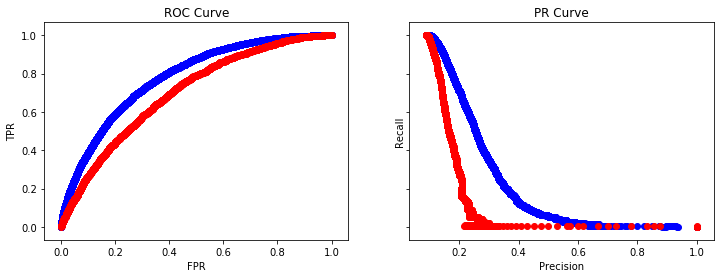

----- C = 0.010000 -----
Time elapsed (Training): 0.3419 s
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906134
ROCAUC Score (Training): 0.770454
PRAUC Score (Training): 0.159063
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.701003
PRAUC Score (Validation): 0.083293
Time elapsed (Evaluation): 0.5078 s


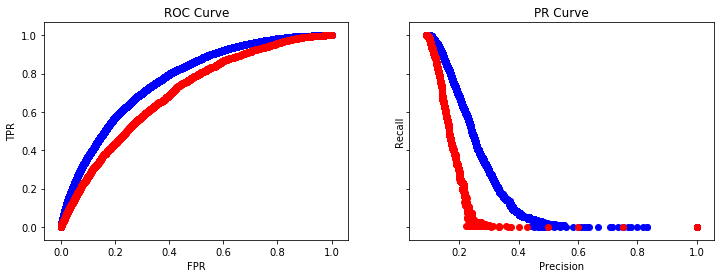

----- C = 0.005000 -----
Time elapsed (Training): 0.3179 s
LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.760225
PRAUC Score (Training): 0.142743
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.700209
PRAUC Score (Validation): 0.082157
Time elapsed (Evaluation): 0.5248 s


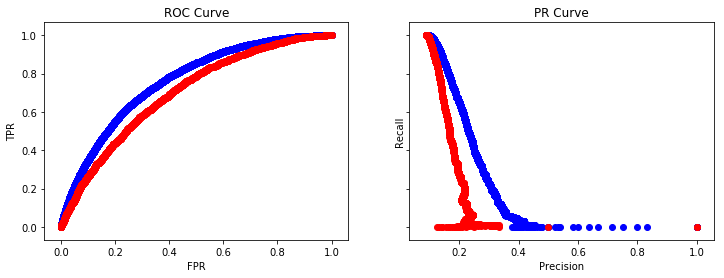

----- C = 0.002000 -----
Time elapsed (Training): 0.3029 s
LogisticRegression(C=0.002, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.745853
PRAUC Score (Training): 0.127163
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.695926
PRAUC Score (Validation): 0.083379
Time elapsed (Evaluation): 0.5808 s


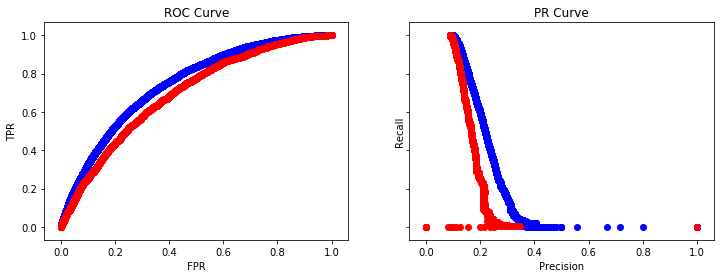

----- C = 0.001000 -----
Time elapsed (Training): 0.2809 s
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.733123
PRAUC Score (Training): 0.117369
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.688428
PRAUC Score (Validation): 0.120437
Time elapsed (Evaluation): 0.5028 s


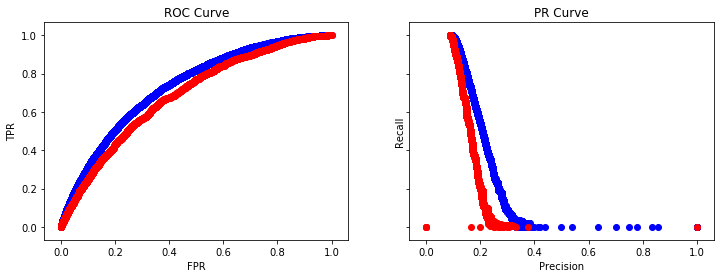

----- C = 0.000500 -----
Time elapsed (Training): 0.2759 s
LogisticRegression(C=0.0005, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.716021
PRAUC Score (Training): 0.105324
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.674740
PRAUC Score (Validation): 0.113953
Time elapsed (Evaluation): 0.5158 s


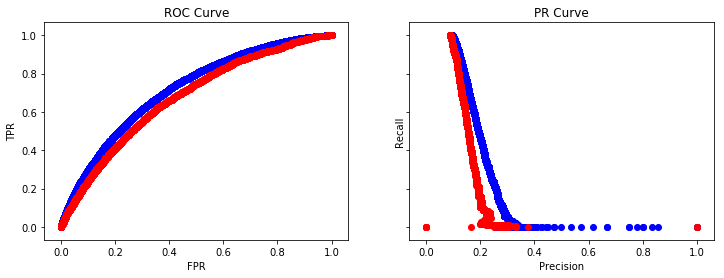

----- C = 0.000200 -----
Time elapsed (Training): 0.2159 s
LogisticRegression(C=0.0002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.676981
PRAUC Score (Training): 0.075160
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.639314
PRAUC Score (Validation): 0.063349
Time elapsed (Evaluation): 0.4768 s


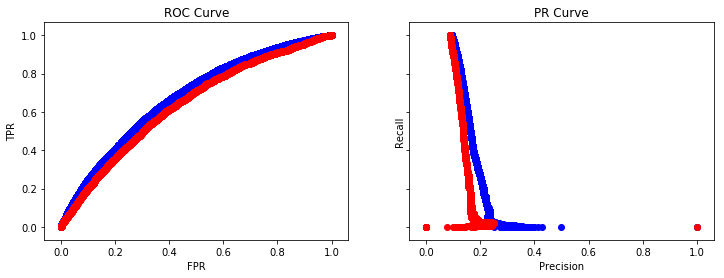

----- C = 0.000100 -----
Time elapsed (Training): 0.2329 s
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.631333
PRAUC Score (Training): 0.045223
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.597573
PRAUC Score (Validation): 0.072421
Time elapsed (Evaluation): 0.4689 s


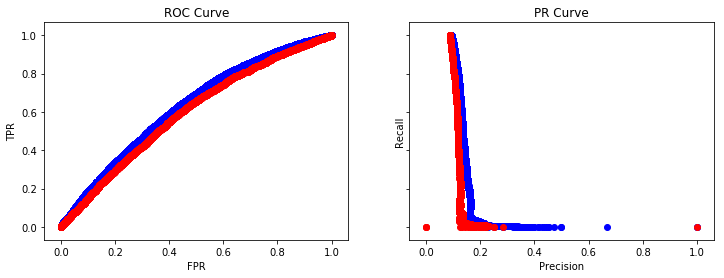

In [18]:
# Train the models with combined features

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

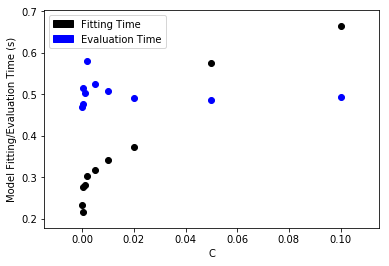

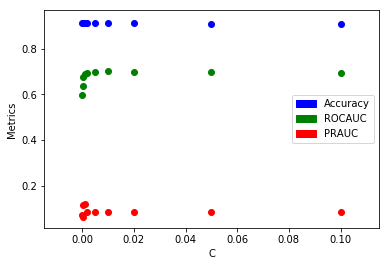

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.910974  0.695559  0.084506    0.664802     0.492840
1  0.0500    0.911496  0.698180  0.085805    0.575811     0.486843
2  0.0200    0.912017  0.700490  0.085550    0.371877     0.490842
3  0.0100    0.911970  0.701003  0.083293    0.341903     0.507836
4  0.0050    0.911827  0.700209  0.082157    0.317900     0.524830
5  0.0020    0.911827  0.695926  0.083379    0.302918     0.580814
6  0.0010    0.911827  0.688428  0.120437    0.280922     0.502837
7  0.0005    0.911827  0.674740  0.113953    0.275912     0.515835
8  0.0002    0.911827  0.639314  0.063349    0.215928     0.476845
9  0.0001    0.911827  0.597573  0.072421    0.232927     0.468850


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.911742   0.679142   0.087485    0.358090     0.504837
std     0.032431    0.000302   0.

In [19]:
utils.plot_metrics (Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

The best ROCAUC is still 0.701. Now adding class weights.

----- C = 0.100000 -----
Time elapsed (Training): 0.8058 s
LogisticRegression(C=0.1, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.684377
ROCAUC Score (Training): 0.803622
PRAUC Score (Training): 0.234350
Accuracy (Validation): 0.656696
ROCAUC Score (Validation): 0.689250
PRAUC Score (Validation): 0.078526
Time elapsed (Evaluation): 0.5248 s


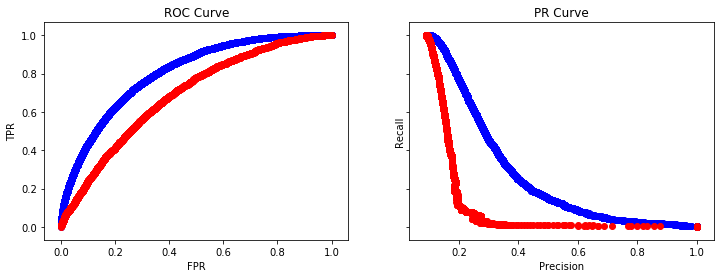

----- C = 0.050000 -----
Time elapsed (Training): 0.8067 s
LogisticRegression(C=0.05, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.681817
ROCAUC Score (Training): 0.801572
PRAUC Score (Training): 0.226879
Accuracy (Validation): 0.654752
ROCAUC Score (Validation): 0.692069
PRAUC Score (Validation): 0.080502
Time elapsed (Evaluation): 0.4858 s


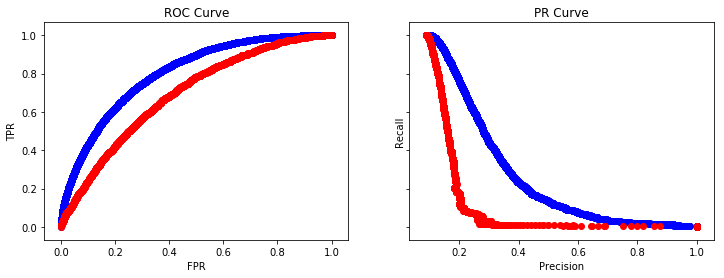

----- C = 0.020000 -----
Time elapsed (Training): 0.5988 s
LogisticRegression(C=0.02, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.675785
ROCAUC Score (Training): 0.796246
PRAUC Score (Training): 0.209181
Accuracy (Validation): 0.650676
ROCAUC Score (Validation): 0.695977
PRAUC Score (Validation): 0.082528
Time elapsed (Evaluation): 0.5318 s


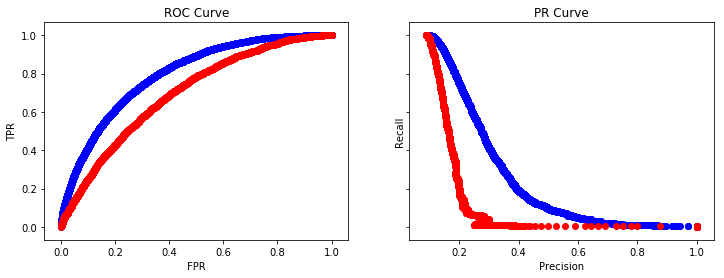

----- C = 0.010000 -----
Time elapsed (Training): 0.5648 s
LogisticRegression(C=0.01, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.670274
ROCAUC Score (Training): 0.789639
PRAUC Score (Training): 0.190344
Accuracy (Validation): 0.646551
ROCAUC Score (Validation): 0.698564
PRAUC Score (Validation): 0.083417
Time elapsed (Evaluation): 0.4978 s


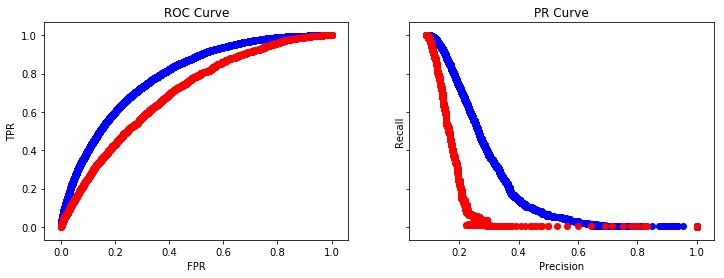

----- C = 0.005000 -----
Time elapsed (Training): 0.4429 s
LogisticRegression(C=0.005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.663684
ROCAUC Score (Training): 0.780892
PRAUC Score (Training): 0.169469
Accuracy (Validation): 0.642617
ROCAUC Score (Validation): 0.700385
PRAUC Score (Validation): 0.082236
Time elapsed (Evaluation): 0.4698 s


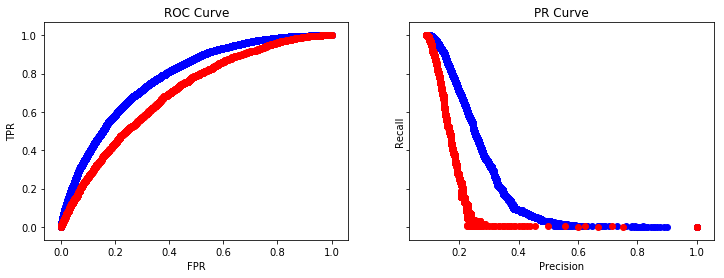

----- C = 0.002000 -----
Time elapsed (Training): 0.3549 s
LogisticRegression(C=0.002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.654060
ROCAUC Score (Training): 0.767305
PRAUC Score (Training): 0.144699
Accuracy (Validation): 0.638113
ROCAUC Score (Validation): 0.701361
PRAUC Score (Validation): 0.079861
Time elapsed (Evaluation): 0.4868 s


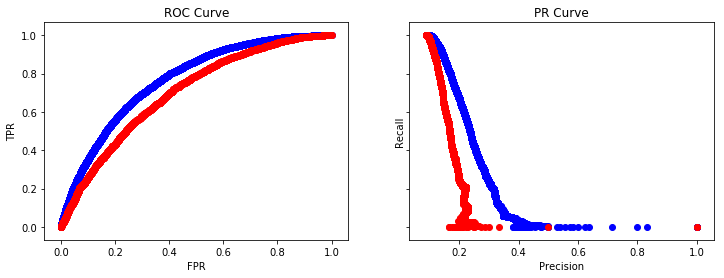

----- C = 0.001000 -----
Time elapsed (Training): 0.2989 s
LogisticRegression(C=0.001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.647803
ROCAUC Score (Training): 0.756554
PRAUC Score (Training): 0.130725
Accuracy (Validation): 0.636217
ROCAUC Score (Validation): 0.700934
PRAUC Score (Validation): 0.082857
Time elapsed (Evaluation): 0.4928 s


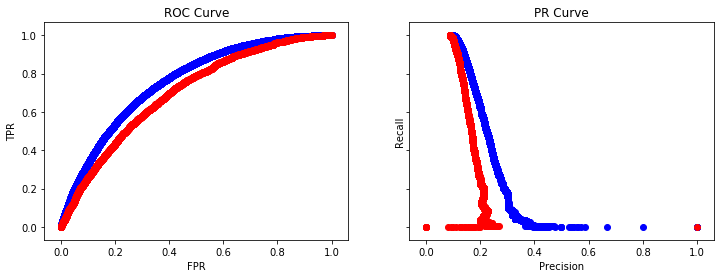

----- C = 0.000500 -----
Time elapsed (Training): 0.2829 s
LogisticRegression(C=0.0005, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.641758
ROCAUC Score (Training): 0.746112
PRAUC Score (Training): 0.119501
Accuracy (Validation): 0.633088
ROCAUC Score (Validation): 0.699541
PRAUC Score (Validation): 0.125281
Time elapsed (Evaluation): 0.4758 s


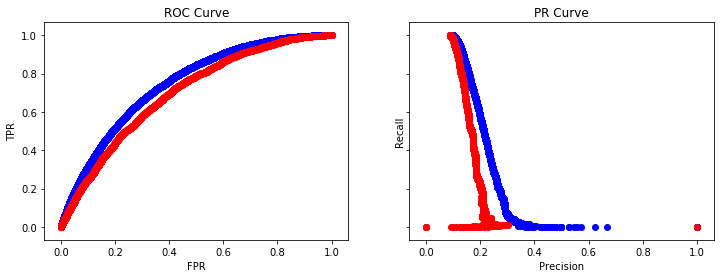

----- C = 0.000200 -----
Time elapsed (Training): 0.2539 s
LogisticRegression(C=0.0002, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.632478
ROCAUC Score (Training): 0.733771
PRAUC Score (Training): 0.108159
Accuracy (Validation): 0.628206
ROCAUC Score (Validation): 0.696455
PRAUC Score (Validation): 0.127972
Time elapsed (Evaluation): 0.5168 s


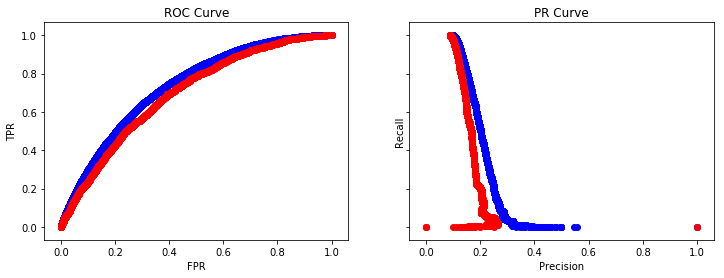

----- C = 0.000100 -----
Time elapsed (Training): 0.2309 s
LogisticRegression(C=0.0001, class_weight={0: 1.0, 1: 10.0}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Accuracy (Training): 0.622843
ROCAUC Score (Training): 0.726223
PRAUC Score (Training): 0.102293
Accuracy (Validation): 0.619863
ROCAUC Score (Validation): 0.693705
PRAUC Score (Validation): 0.123156
Time elapsed (Evaluation): 0.4898 s


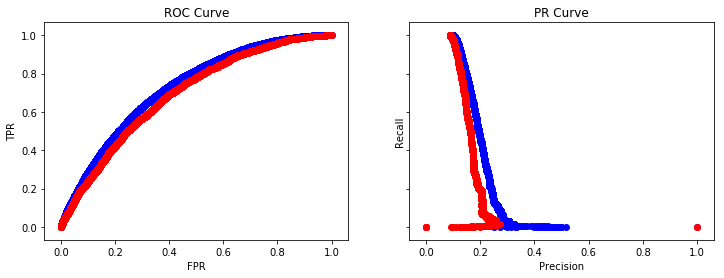

In [20]:
# Train the models with combined features

fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; prauc_scores = []

for C in Cs:
    print('----- C = %f -----' % C)
    clf = linear_model.LogisticRegression(class_weight=class_weight, C=C)
    fit_time = utils.train_model(clf, X_train, y_train)
    acc_score, rocauc_score, prauc_score, eval_time = utils.evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); prauc_scores.append(prauc_score)

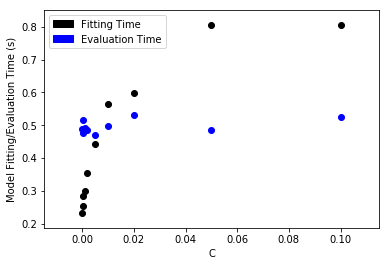

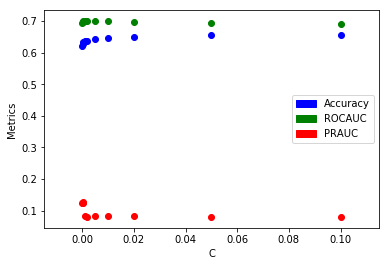

      0_C  1_Accuracy  2_ROCAUC   3_PRAUC  4_fit_time  5_eval_time
0  0.1000    0.656696  0.689250  0.078526    0.805758     0.524830
1  0.0500    0.654752  0.692069  0.080502    0.806742     0.485827
2  0.0200    0.650676  0.695977  0.082528    0.598808     0.531829
3  0.0100    0.646551  0.698564  0.083417    0.564816     0.497838
4  0.0050    0.642617  0.700385  0.082236    0.442871     0.469847
5  0.0020    0.638113  0.701361  0.079861    0.354887     0.486845
6  0.0010    0.636217  0.700934  0.082857    0.298900     0.492843
7  0.0005    0.633088  0.699541  0.125281    0.282907     0.475847
8  0.0002    0.628206  0.696455  0.127972    0.253919     0.516835
9  0.0001    0.619863  0.693705  0.123156    0.230923     0.489842


             0_C  1_Accuracy   2_ROCAUC    3_PRAUC  4_fit_time  5_eval_time
count  10.000000   10.000000  10.000000  10.000000   10.000000    10.000000
mean    0.018880    0.640678   0.696824   0.094634    0.464053     0.497238
std     0.032431    0.011859   0.

In [21]:
utils.plot_metrics (Cs, 'C', True, fit_times, eval_times, acc_scores, rocauc_scores, prauc_scores)

The best ROCAUC is still 0.701.

In [23]:
# Save the new features to a CSV file

df_combined = pd.concat([df_combined, df['loss']], axis=1)
df_combined.to_csv('train_v2_normalized_with_gb_leaf.csv')